# Self-Improving Email Assistant

AI agents promise to transform how we work, but there's often a gap between hype and reality: to truly act on our behalf as *useful* agents, there's a lot oof details to get right. In this repo, we're going to show how to build useful agents from scratch using LangChain, LangGraph, and LangSmith. 
 
We're going to build an agent that can act an an e-mail assistant, because this is often a rather tedious task that could benefit from an AI assistant, but it requires a high level of personalization (e.g., what to respond to, what to ignore, what to schedule a meeting for, and how to respond) and involves sensitive actions. 

Below is an overview of the email assistant we'll build with 1) the agent architecture (LangGraph), 2) testing (LangSmith), 3) human-in-the-loop (Agent Inbox), and 4) memory. The notebooks are organized in the order of the steps, so you can follow along and accompanying completed code is in the `src/email_assistant` directory.

![overview-img](img/overview.png)

## What are Agents?

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) are systems where language models (LLMs) dynamically direct their own processes and tool usage. Unlike workflows with predefined paths, agents can make decisions about which actions to take based on their understanding of a task. Agents are particularly valuable for open-ended problems like email management, where it's difficult to predict the *exact* steps needed in advance: some emails can be responded to directly and some need coordination with tools (e.g, scheduling a meeting).

![agent-img](img/agent.png)

### Tool Definition

 As you will see, agents are typically implemented [using tool calling in a loop](https://python.langchain.com/docs/concepts/tool_calling/). Tools let agents interact with their environment. In LangChain/Graph, tools are easy to define: we can just use Python functions with the [@tool decorator](https://python.langchain.com/docs/concepts/tools/) or [MCP servers](https://github.com/langchain-ai/langchain-mcp-adapters). Let's start by defining some simple tools that an email assistant will use with the `@tool` decorator:

In [25]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
def triage_email(category: Literal["ignore", "notify", "respond"]) -> str:
    """Triage an email into one of three categories: ignore, notify, respond."""
    return f"Classification Decision: {category}"

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

### Augmenting the LLM with Tools

Now we connect these tools to a LLM. We'll use LangChain's [`init_chat_model`](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html#init-chat-model) interface, which allows us to initialize many different chat models. We [enforce tool use](https://python.langchain.com/docs/how_to/tool_choice/) by setting `tool_choice="required"` and set the temperature to `0.0` to make the agent more deterministic.

![agent-img](img/agent_loop.png)

In [26]:
from langchain.chat_models import init_chat_model

# Collect all tools
tools = [write_email, schedule_meeting, check_calendar_availability, triage_email, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

## Agent Orchestration with LangGraph

Now we have an LLM with tools; how can we orchestrate it as an agent? This is where LangGraph comes in. We can create an agent using LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) by passing in the LLM, tools, and prompt. 

![overview-img](img/overview_agent.png)

In [27]:
from langgraph.prebuilt import create_react_agent
from src.email_assistant.prompts import agent_system_prompt_baseline, default_background, default_response_preferences, default_cal_preferences, default_triage_instructions

# Pass in:
# (1) the LLM
# (2) the tools list
# (3) the prompt

# Agent system prompt
system_prompt = """
< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:
1. triage_email(ignore, notify, respond) - Triage emails into one of three categories
2. write_email(to, subject, content) - Send emails to specified recipients
3. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
4. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. For responding to the email, draft a response email with the write_email tool
3. For meeting requests, use the check_calendar_availability tool to find open time slots
4. To schedule a meeting, use the the schedule_meeting tool 
5. If you scheduled a meeting, then draft a short response email using the write_email tool
6. After using the write_email tool, the task is complete 
</ Instructions >

< Triage Instructions >
Emails that are not worth responding to:
- Marketing newsletters and promotional emails and spam

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation

Emails that are worth responding to:
- System Admin notifications (use a brief thank you for the email)
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
</ Triage Instructions >
"""

# Create the agent
pre_built_agent = create_react_agent(model=init_chat_model("openai:gpt-4o", temperature=0.0), 
                                     tools=[write_email, schedule_meeting, check_calendar_availability, triage_email], 
                                     prompt=system_prompt)

# Email input
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
messages = [{"role": "user", "content": str(email_input)}]
response = pre_built_agent.invoke({"messages": messages})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

{'author': 'System Admin <sysadmin@company.com>', 'to': 'Development Team <dev@company.com>', 'subject': 'Scheduled maintenance - database downtime', 'email_thread': "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"}
================================== Ai Message ==================================
Tool Calls:
  triage_email (call_GtA4mvnomCgvedNMn4bgGugE)
 Call ID: call_GtA4mvnomCgvedNMn4bgGugE
  Args:
    category: respond
================================= Tool Message =================================
Name: triage_email

Classification Decision: respond
================================== Ai Message ============================

We mentioned that agents typically use tool calling in a loop. [ReAct](https://arxiv.org/abs/2210.03629) is an architecture that implements this, using a loop of reasoning and tool calling that only exits when the LLM decides to no longer call any tools. To understand what happens under the hood when we using the `create_react_agent` pre-built method, below we'll break down the components of the agent in detail. 

### Agent State

When building an agent, it's important to consider the information that you want to track over time. LangGraph allows you to define a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that defines a schema for this information. It can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object. 
 
Because it's so common to track a list of [messages](https://python.langchain.com/docs/concepts/messages/#), LangGraph provides a [`MessagesState` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) that is a just dictionary with a `messages` key. However, LangGraph gives you flexibility to track other information. As an example, we can define a custom `State` object that extends `MessagesState` and adds a `classification_decision` key:

In [28]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # This state class has the messages key build in
    classification_decision: Literal["ignore", "respond", "notify"]

This means that our graph has two keys in the state: `messages` and `classification_decision`. 

### Agent nodes

Under the hood of `pre_built_agent`, LangGraph uses a [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) that defines the flow of information and decision-making in your agent through nodes, edges, and conditional routing. 

- **Nodes**: Functions that process state
- **Edges**: Connections that define how state flows between nodes
- **Conditional routing**: Dynamic decision-making

In the case of an agent this is straightforward: 

- **Nodes**: Perform the LLM decision-making and tool calling
- **Edges**: LLM decision-making and tool calling nodes are connected
- **Conditional routing**: Route from LLM decision to tool calling if a tool is called

#### LLM Decision-making node

Here, we define the LLM decision-making node. This node takes in the current state, calls the LLM, and updates `messages` with the LLM output. 

In [29]:
%cd ..
%load_ext autoreload
%autoreload 2

from src.email_assistant.tools.default.prompt_templates import STANDARD_TOOLS_PROMPT
from src.email_assistant.prompts import agent_system_prompt_baseline, default_background, default_response_preferences, default_cal_preferences, default_triage_instructions

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [   
                    {"role": "system", "content": agent_system_prompt_baseline.format(
                        tools_prompt=STANDARD_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences, 
                        triage_instructions=default_triage_instructions
                    )}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

/Users
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We return a dictionary to update the state. Each of our state keys handles updates individually. By default an update will *overwrite* the existing state key. However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). For example, `messages` key in the built-in `MessagesState` appends new messages to the list. 

#### Handling Tool Calls

After the LLM makes a decision, we need to execute the chosen tool. The `tool_handler` node executes the tool. We can see that nodes can update the graph state to capture any important state changes, such as the classification decision.

In [30]:
def tool_handler(state: State):
    """Process tool calls and execute them"""
    
    # Store messages
    result = []
    # Track if we need to update classification_decision
    classification_decision = None
    
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Execute the tool
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        # Log the classification decision if triage_email was called
        if tool_call["name"] == "triage_email":
            # Get the classification decision from the tool call
            classification_decision = tool_call["args"]["category"]
        # Add the tool response
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    
    # Return updated state 
    if classification_decision:
        return {
            # Append the tool result to the messages
            "messages": result,
            # Update the classification decision
            "classification_decision": classification_decision
        }
    else:
        # If no tool was called, append the tool result to the messages
        return {"messages": result}

### Agent Conditional Routing

Our agent needs to decide when to continue using tools and when to stop. This conditional routing function directs the agent to either continue or terminate.

In [31]:
from langgraph.graph import END
def should_continue(state: State) -> Literal["tool_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

### Agent Graph

Finally, we can assemble all components into a LangGraph state graph:

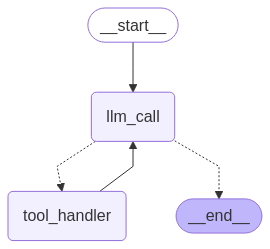

In [32]:
from langgraph.graph import StateGraph, START, END

# Build workflow
overall_workflow = StateGraph(State, input=MessagesState)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

# View
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

This creates a graph that:
1. Starts with an LLM decision
2. Conditionally routes to tool execution or termination
3. After tool execution, returns to LLM for the next decision
4. Repeats until completion or no tool is called

We can run the agent with a simple email input. The compiled agent has an interface with [various useful methods](https://python.langchain.com/docs/concepts/runnables/), including `invoke()`, which takes in a `state` dictionary and returns the final state. However, as we'll see later, we can also stream the agent's execution.

In [33]:
# Email input
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Invoke the agent
messages = [{"role": "user", "content": str(email_input)}]
response = agent.invoke({"messages": messages})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

{'author': 'System Admin <sysadmin@company.com>', 'to': 'Development Team <dev@company.com>', 'subject': 'Scheduled maintenance - database downtime', 'email_thread': "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"}
================================== Ai Message ==================================
Tool Calls:
  triage_email (call_hOCONCJ0hIjGEsGeV1luxExX)
 Call ID: call_hOCONCJ0hIjGEsGeV1luxExX
  Args:
    category: notify
================================= Tool Message =================================

Classification Decision: notify
================================== Ai Message ==================================
Tool Calls:
  

## Information Flow

The complete flow of our email assistant agent:

1. An email arrives and is passed to the agent as a message
2. The LLM analyzes the email and decides which tool to use
3. If the LLM calls the `triage_email` tool, the classification is stored
4. The agent continues reasoning and acting until it calls `Done`
5. The final state includes the messages and any classification decision

This implementation demonstrates a tool calling agent that alternates between reasoning (LLM decisions) and acting (tool execution) to accomplish complex tasks.

## Workflows vs. Agents

We can see that it's easy to build an agent using LangGraph. But, what if we want to add more tools? You'll notice that the agent's prompt and scope of control grows as the number of tools / decisions it oversees increases. When we think about our application, we *always* want to triage incoming emails. So, we know that the first step is always going to be a triage step. Why not set up our application so that the first step is always the triage step? This is the motivation for the concept of a [workflow](https://langchain-ai.github.io/langgraph/how-tos/workflows/)!  

### Workflows
- Have predefined code paths and decision logic
- LLMs are components used for specific tasks
- Best for structured problems with clear procedures, but not open-ended
- Predictable behavior with explicit control flow

### Agents
- LLMs drive the decision-making process
- Dynamically choose which tools to use
- Best for open-ended problems where we can't enumerate the steps  
- More flexible but potentially less reliable

![agent_workflow_img](img/agent_workflow.png)

### Combing the two
We can use LangGraph to build a routing step prior to the agent, which handles the triage decision. This has some benefits, including separation of concerns. The triage router only focuses on the triage decision, while the agent focuses *only* on the response. As we'll see, this *separation of concerns* is useful because we'll add more tools to our agent. Breaking out the triage decision frees up some "cognitive resources" for the agent to focus only on the response. 

![agent_workflow_img](img/workflow_v_agent.png)

### The Triage Router

Our email assistant implementation uses a router pattern. The router analyzes the email and makes a critical decision: should we respond, notify, or ignore? Based on this decision, it directs the flow either to the response agent or directly to the end state. We use [Command](https://langchain-ai.github.io/langgraph/how-tos/command/) objects in LangGraph to both update the state and select the next node to visit.

![router-img](img/router.png)

In [34]:
from email_assistant.schemas import RouterSchema
from email_assistant.utils import parse_email, format_email_markdown
from email_assistant.prompts import triage_system_prompt, triage_user_prompt

from langgraph.types import Command

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4o", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

class State(MessagesState):
    # We can add a specific key to our state for the email input
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [{
                    "role": "user",
                    "content": f"E-mail classification Decision: {result.classification} is done.",
                },
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification,
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update =  {
            "messages": [
                {
                    "role": "user",
                    "content": f"E-mail classification Decision: {result.classification} is done."
                }
            ],
            "classification_decision": result.classification,
        }
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"E-mail classification Decision: {result.classification} is done."
                }
            ],
            "classification_decision": result.classification,
        }
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

### Building the Workflow with a Router

With the router pattern, our overall workflow becomes a composition of components:

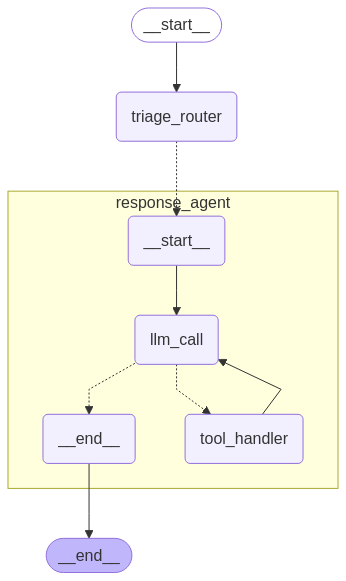

In [35]:
class State(MessagesState):
    # This state class has the messages key build in
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

# View
from IPython.display import Image, display
display(Image(overall_workflow.get_graph(xray=True).draw_mermaid_png()))

This is a higher-level composition where:
1. First, the triage router analyzes the email
2. If needed, the response agent handles crafting a response
3. The workflow ends when either the triage decides no response is needed or the response agent completes

In [36]:
# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information
================================ Human Message =================================

E-mail classification Decision: notify is done.


## Testing with Local Deployment

You can find files for these in the `src/email_assistant` directory:

* `src/email_assistant/baseline_agent.py` 
* `src/email_assistant/email_assistant.py`

You can test them locally in LangGraph Studio by running:

In [ ]:
! langgraph dev

Example e-mail you can test:

In [ ]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

![studio-img](img/studio.png)